In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# IMPORT IMAGES

In [4]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

228813984/228813984 [==============================] - 112s 0us/step


In [5]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('datasets/flower_photos')

In [6]:
list(data_dir.glob('*/*.jpg'))[:5]

[WindowsPath('datasets/flower_photos/daisy/100080576_f52e8ee070_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10140303196_b88d3d6cec.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172379554_b296050f82_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172567486_2748826a8b.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172636503_21bededa75_n.jpg')]

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [8]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[WindowsPath('datasets/flower_photos/roses/10090824183_d02c613f10_m.jpg'),
 WindowsPath('datasets/flower_photos/roses/102501987_3cdb8e5394_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/10503217854_e66a804309.jpg'),
 WindowsPath('datasets/flower_photos/roses/10894627425_ec76bbc757_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/110472418_87b6a3aa98_m.jpg')]

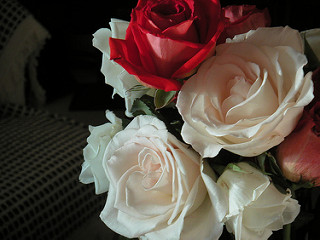

In [10]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [11]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [12]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

# OPEN CV to convert images into numpy array

In [15]:
img = cv2.imread(str(flowers_images_dict['roses'][0])) #needs str input

In [16]:
img.shape

(240, 179, 3)

In [17]:
cv2.resize(img,(180,180)).shape

(180, 180, 3)

In [18]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(180,180))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])
X = np.array(X)
y = np.array(y)

In [20]:
X.shape

(3670, 180, 180, 3)

In [21]:
X = np.array(X)
y = np.array(y)

# K MEANS TO SPLIT

In [22]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 3) #usually n_splits = 10

In [23]:
for train_index, test_index in kf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index],y[train_index], y[test_index]

In [24]:
X_train.shape

(2447, 180, 180, 3)

In [25]:
X_test.shape

(1223, 180, 180, 3)

# SCALING

In [26]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

# CNN

In [27]:
num_classes = 5

In [30]:
model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
model.fit(X_train_scaled, y_train, epochs=5) 

Epoch 1/5
77/77 [==============================] - 19s 229ms/step - loss: 1.1381 - accuracy: 0.4863
Epoch 2/5
77/77 [==============================] - 17s 217ms/step - loss: 0.7722 - accuracy: 0.6886
Epoch 3/5
77/77 [==============================] - 19s 254ms/step - loss: 0.5925 - accuracy: 0.7716
Epoch 4/5
77/77 [==============================] - 20s 263ms/step - loss: 0.4397 - accuracy: 0.8300
Epoch 5/5
77/77 [==============================] - 18s 239ms/step - loss: 0.3051 - accuracy: 0.8933


In [31]:
model.evaluate(X_test_scaled,y_test)

39/39 [==============================] - 2s 41ms/step - loss: 12.3311 - accuracy: 0.2903


[12.331052780151367, 0.2902698218822479]

In [32]:
score = tf.nn.softmax(predictions[0])

NameError: name 'predictions' is not defined

# Improve Test Accuracy Using Data Augmentation

In [35]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

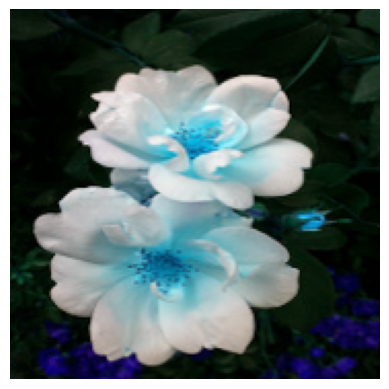

In [36]:
plt.axis('off')
plt.imshow(X[0])

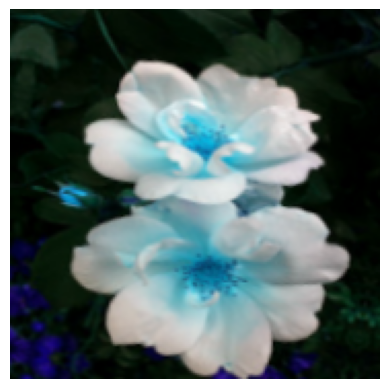

In [38]:
plt.axis('off')
plt.imshow(data_augmentation(X)[0].numpy().astype("uint8"))

In [39]:
num_classes = 5

model = Sequential([
  data_augmentation, #######important!!
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), #####20% neurons dropout
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
model.fit(X_train_scaled, y_train, epochs=5)    

Epoch 1/5
77/77 [==============================] - 25s 309ms/step - loss: 1.0462 - accuracy: 0.5321
Epoch 2/5
77/77 [==============================] - 19s 251ms/step - loss: 0.7850 - accuracy: 0.6882
Epoch 3/5
77/77 [==============================] - 19s 243ms/step - loss: 0.7001 - accuracy: 0.7278
Epoch 4/5
77/77 [==============================] - 19s 250ms/step - loss: 0.6491 - accuracy: 0.7438
Epoch 5/5
77/77 [==============================] - 19s 253ms/step - loss: 0.6350 - accuracy: 0.7540


In [41]:
model.evaluate(X_test_scaled, y_test)

39/39 [==============================] - 2s 44ms/step - loss: 8.4021 - accuracy: 0.2191


[8.402083396911621, 0.21913327276706696]